## Script to determine solar storm level as defined by NOAA

A short program that calculates and plots the total integrated proton flux above 10 MeV for a given month from GOES satellite data, available in CSV format from the NOAA website. 

#### Setting up the pandas, numpy and matplotlib routines.

In [97]:
# Import pandas, numpy and matplotlib packages
import warnings
warnings.simplefilter('ignore', FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import datetime as datetime

The program reads in the variables for the month, number of days in the month, year and number of the GOES satellite for the data to be processed, as defined by the user via input boxes.

A good example of solar storm data requires: year=2015, month=06, days=30, satnumber=13
This particular set of data shows very visible solar storm activity in the final plot.

In [99]:
# Input the year of the data used
YYYY = input('Which year? (Enter 4 digit number)')

# Input the month of the data used
MM = input('Which month? (Enter in MM format)')

# Input the number of days in the month used
DD = input('How many days are in that month?') # i.e. end-date

# Input the number of the GOES satellite number
NN = input('What is the number of the GOES satellite?')

Which year? (Enter 4 digit number) 2015
Which month? (Enter in MM format) 06
How many days are in that month? 30
What is the number of the GOES satellite? 13


The above strings will be used to create new strings below to hold the full URLs of the two CSV files for the required datasets, i.e. one for the EPEAD (Energetic Proton, Electron and Alpha Detectors) data, and one for the HEPAD (High Energy Proton and Alpha Detector) data on board the satellite. 


The columns containing the date & time data in both dataframes are then converted into datetime64 format.

In [101]:
# EPEAD URL string
EPEAD = 'https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/'+YYYY+'/'+MM+'/goes'+NN+'/csv/g'+NN+'_epead_p17ew_5m_'+YYYY+MM+'01_'+YYYY+MM+DD+'.csv'

nEhead = 672 + int(DD) # Calculating the header row value and storing in variable nEhead - For EPEAD data, this is row number 672 + number of days input for that specific month)

dfE = pd.read_csv(EPEAD, header=nEhead) # Read in the EPEAD data from CSV to dataframe dfE

In [102]:
# HEPAD URL string
HEPAD = 'https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/'+YYYY+'/'+MM+'/goes'+NN+'/csv/g'+NN+'_hepad_ap_5m_'+YYYY+MM+'01_'+YYYY+MM+DD+'.csv'

nHhead = 254 + int(DD) # Calculating the header row value and storing in variable nHhead - (Row number 254 + number of days input for that specific month)

dfH = pd.read_csv(HEPAD, header=nHhead) # Read in the HEPAD data from CSV to dataframe dfH

dfE['time_tag'] = pd.to_datetime(dfE['time_tag']) # Convert each date/time column labelled 'time_tag' into datetime64 format - convert EPEAD dataframe's 'time_tag' column to datetime64 format

dfH['time_tag'] = pd.to_datetime(dfH['time_tag']) # Convert HEPAD dataframe's 'time_tag' column to datetime64 format

In [103]:
# Keep only rows where all data quality flags are zero for each dataframe
# Sum of quality flags for east-facing detector
dfE['TOT_QUALE'] = dfE['P2E_QUAL_FLAG'] + dfE['P3E_QUAL_FLAG'] + dfE['P4E_QUAL_FLAG'] + dfE['P5E_QUAL_FLAG'] + dfE['P6E_QUAL_FLAG'] + dfE['P7E_QUAL_FLAG']

# Sum of quality flags for west-facing detector
dfE['TOT_QUALW'] = dfE['P2W_QUAL_FLAG'] + dfE['P3W_QUAL_FLAG'] + dfE['P4W_QUAL_FLAG'] + dfE['P5W_QUAL_FLAG'] + dfE['P6W_QUAL_FLAG'] + dfE['P7W_QUAL_FLAG']

dfE['TOT_QUAL'] = dfE['TOT_QUALE']+dfE['TOT_QUALW'] # Sum of both east and west detectors quality flags

dfE = dfE[dfE.TOT_QUAL == 0] # Creating new dataframe of rows where the sum of quality flags for both detectors is zero

dfH['TOT_QUAL'] = dfH['P8_QUAL_FLAG'] + dfH['P9_QUAL_FLAG'] + dfH['P10_QUAL_FLAG'] + dfH['P11_QUAL_FLAG'] # For HEPAD, sum all quality flags

dfH = dfH[dfH.TOT_QUAL == 0] # Creating new dataframe of rows where the sum of quality flags is zero

Below we take averages of the East & West corrected fluxes in the P2 - P7 proton detector channels, and only the required corrected proton fluxes and the times at which they occured are carried forward.

In [105]:
# Calculate the average for the east and west detector corrected fluxes in each proton channel

dfE['P2_FLUX']=(dfE['P2E_COR_FLUX']+dfE['P2W_COR_FLUX'])/2 # Average corrected flux for proton channel P2

dfE['P3_FLUX']=(dfE['P3E_COR_FLUX']+dfE['P3W_COR_FLUX'])/2 # Average corrected flux for proton channel P3

dfE['P4_FLUX']=(dfE['P4E_COR_FLUX']+dfE['P4W_COR_FLUX'])/2 # Average corrected flux for proton channel P4

dfE['P5_FLUX']=(dfE['P5E_COR_FLUX']+dfE['P5W_COR_FLUX'])/2 # Average corrected flux for proton channel P5

dfE['P6_FLUX']=(dfE['P6E_COR_FLUX']+dfE['P6W_COR_FLUX'])/2# Average corrected flux for proton channel P6

dfE['P7_FLUX']=(dfE['P7E_COR_FLUX']+dfE['P7W_COR_FLUX'])/2 # Average corrected flux for proton channel P7

dfE = dfE[['time_tag', 'P2_FLUX', 'P3_FLUX', 'P4_FLUX', 'P5_FLUX','P6_FLUX', 'P7_FLUX']] # Storing only EPEAD average corrected flux across east and west detectors and time data in dataframe

dfH = dfH[['time_tag', 'P8_FLUX', 'P9_FLUX', 'P10_FLUX', 'P11_FLUX']] # Storing only HEPAD corrected fluxes for each proton channel and time data in dataframe

These dataframes for EPEAD and HEPAD are now joined on 'time_tag' column with an inner join to create one dataframe, and only rows with valid data entries are kept in.

In [107]:
dfEH = pd.merge(dfE, dfH, on='time_tag', how='inner')

The effective energy of each proton channel is the geometric mean of the channel boundary energies.

In [109]:
E2 = (4.2*8.7)**0.5
E3 = 11.2
E4 = 24.5
E5 = 55.8
E6 = 130
E7 = 315
E8 = 372
E9 = 463
E10 = 598
E11 = 1000.0

The piece-wise power-law slopes and normalisations between each pair of energy values are calculated as:

In [111]:
# Calculate the piece-wise power law slopes and normalisation between energy values 2 & 3, 3 & 4, 4 & 5, etc.
dfEH['alpha_23'] = (np.log10(dfEH['P3_FLUX'])-np.log10(dfEH['P2_FLUX'])) / (np.log10(E3)-np.log10(E2))
dfEH['A_23'] = 10**(np.log10(dfEH['P2_FLUX'])-(dfEH['alpha_23']*np.log10(E2)))

dfEH['alpha_34'] = (np.log10(dfEH['P4_FLUX'])-np.log10(dfEH['P3_FLUX'])) / (np.log10(E4)-np.log10(E3))
dfEH['A_34'] = 10**(np.log10(dfEH['P3_FLUX'])-(dfEH['alpha_34']*np.log10(E3)))

dfEH['alpha_45'] = (np.log10(dfEH['P5_FLUX'])-np.log10(dfEH['P4_FLUX'])) / (np.log10(E5)-np.log10(E4))
dfEH['A_45'] = 10**(np.log10(dfEH['P4_FLUX'])-(dfEH['alpha_45']*np.log10(E4)))

dfEH['alpha_56'] = (np.log10(dfEH['P6_FLUX'])-np.log10(dfEH['P5_FLUX'])) / (np.log10(E6)-np.log10(E5))
dfEH['A_56'] = 10**(np.log10(dfEH['P5_FLUX'])-(dfEH['alpha_56']*np.log10(E5)))

dfEH['alpha_67'] = (np.log10(dfEH['P7_FLUX'])-np.log10(dfEH['P6_FLUX'])) / (np.log10(E7)-np.log10(E6))
dfEH['A_67'] = 10**(np.log10(dfEH['P6_FLUX'])-(dfEH['alpha_67']*np.log10(E6)))

dfEH['alpha_78'] = (np.log10(dfEH['P8_FLUX'])-np.log10(dfEH['P7_FLUX'])) / (np.log10(E8)-np.log10(E7))
dfEH['A_78'] = 10**(np.log10(dfEH['P7_FLUX'])-(dfEH['alpha_78']*np.log10(E7)))

dfEH['alpha_89'] = (np.log10(dfEH['P9_FLUX'])-np.log10(dfEH['P8_FLUX'])) / (np.log10(E9)-np.log10(E8))
dfEH['A_89'] = 10**(np.log10(dfEH['P8_FLUX'])-(dfEH['alpha_89']*np.log10(E8)))

dfEH['alpha_910'] = (np.log10(dfEH['P10_FLUX'])-np.log10(dfEH['P9_FLUX'])) / (np.log10(E10)-np.log10(E9))
dfEH['A_910'] = 10**(np.log10(dfEH['P9_FLUX'])-(dfEH['alpha_910']*math.log10(E9)))

dfEH['alpha_1011'] = (np.log10(dfEH['P11_FLUX'])-np.log10(dfEH['P10_FLUX'])) / (np.log10(E11)-np.log10(E10))
dfEH['A_1011'] = 10**(np.log10(dfEH['P10_FLUX'])-(dfEH['alpha_1011']*np.log10(E10)))

The integrated proton flux across each of the channels from 10 MeV to 1000 MeV can be calculated as below.

In [113]:
# Calculate the integrated proton flux from 10 MeV to 1000 MeV across channels 2 & 3, 3 & 4, 4 & 5, etc
dfEH['totflux_23'] = (dfEH['A_23']/(dfEH['alpha_23']+1))*(E3**(dfEH['alpha_23']+1)-E2**(dfEH['alpha_23']+1))

dfEH['totflux_34'] = (dfEH['A_34']/(dfEH['alpha_34']+1))*(E4**(dfEH['alpha_34']+1)-E3**(dfEH['alpha_34']+1))

dfEH['totflux_45'] = (dfEH['A_45']/(dfEH['alpha_45']+1))*(E5**(dfEH['alpha_45']+1)-E4**(dfEH['alpha_45']+1))

dfEH['totflux_56'] = (dfEH['A_56']/(dfEH['alpha_56']+1))*(E6**(dfEH['alpha_56']+1)-E5**(dfEH['alpha_56']+1))

dfEH['totflux_67'] = (dfEH['A_67']/(dfEH['alpha_67']+1))*(E7**(dfEH['alpha_67']+1)-E6**(dfEH['alpha_67']+1))

dfEH['totflux_78'] = (dfEH['A_78']/(dfEH['alpha_78']+1))*(E8**(dfEH['alpha_78']+1)-E7**(dfEH['alpha_78']+1))

dfEH['totflux_89'] = (dfEH['A_89']/(dfEH['alpha_89']+1))*(E9**(dfEH['alpha_89']+1)-E8**(dfEH['alpha_89']+1))

dfEH['totflux_910'] = (dfEH['A_910']/(dfEH['alpha_910']+1))*(E10**(dfEH['alpha_910']+1)-E9**(dfEH['alpha_910']+1))

dfEH['totflux_1011'] = (dfEH['A_1011']/(dfEH['alpha_1011']+1))*(E11**(dfEH['alpha_1011']+1)-E10**(dfEH['alpha_1011']+1))

And finally, the total integrated proton flux above 10 MeV is obtained by summing the individual channel integrated fluxes, and from this the solar storm level can be determined.

In [115]:
dfEH['totflux'] = dfEH['totflux_23'] + dfEH['totflux_34'] + dfEH['totflux_45'] + dfEH['totflux_56'] + dfEH['totflux_67'] + dfEH['totflux_78'] + dfEH['totflux_89'] + dfEH['totflux_910'] + dfEH['totflux_1011']

dfEH['storm'] = np.floor((np.log10(dfEH['totflux'])))# Determine the solar storm level by taking the logarithm of the total integrated flux above 10 MeV to the base 10 - Round this value down to the next integer with floor method and display
dfEH

,time_tag,P2_FLUX,P3_FLUX,P4_FLUX,P5_FLUX,P6_FLUX,P7_FLUX,P8_FLUX,P9_FLUX,P10_FLUX,...,totflux_34,totflux_45,totflux_56,totflux_67,totflux_78,totflux_89,totflux_910,totflux_1011,totflux,storm
0,2015-06-01 00:00:00,0.021475,0.007584,0.001233,0.000731,0.000251,0.000200,0.001536,0.001355,0.000339,...,0.041436,0.028991,0.030934,0.040859,0.038331,0.131056,0.096148,0.077660,0.550661,-1.0
1,2015-06-01 00:05:00,0.045374,0.007584,0.002530,0.000731,0.000172,0.000053,0.001762,0.000768,0.000414,...,0.057029,0.041678,0.025919,0.017104,0.028894,0.107275,0.076325,0.076977,0.530818,-1.0
2,2015-06-01 00:10:00,0.033825,0.003448,0.001631,0.001244,0.000570,0.000070,0.001174,0.000994,0.000414,...,0.030749,0.043899,0.060646,0.038077,0.023139,0.098119,0.087743,0.086886,0.530623,-1.0
3,2015-06-01 00:15:00,0.027086,0.003448,0.003914,0.000873,0.000172,0.000096,0.001626,0.001129,0.000376,...,0.049287,0.057326,0.028614,0.023071,0.031882,0.123170,0.090392,0.089222,0.546377,-1.0
4,2015-06-01 00:20:00,0.027227,0.003448,0.001233,0.000731,0.000370,0.000053,0.001265,0.001084,0.000395,...,0.026797,0.028991,0.037495,0.026194,0.022567,0.106355,0.090218,0.085287,0.477488,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,2015-06-30 23:35:00,0.109048,0.010804,0.002574,0.000685,0.000557,0.000069,0.001355,0.000813,0.000358,...,0.069593,0.040838,0.045282,0.037338,0.025541,0.095661,0.073562,0.081907,0.665514,-1.0
8509,2015-06-30 23:40:00,0.274590,0.018255,0.002764,0.000685,0.000479,0.000299,0.001581,0.000813,0.000188,...,0.096866,0.042456,0.041664,0.068211,0.044834,0.103814,0.055921,0.059958,0.942331,-1.0
8510,2015-06-30 23:45:00,0.214534,0.003838,0.001418,0.000685,0.000155,0.000187,0.001852,0.000994,0.000320,...,0.030307,0.030011,0.023885,0.031978,0.042604,0.124034,0.078369,0.085674,0.673831,-1.0
8511,2015-06-30 23:50:00,0.238438,0.006495,0.001458,0.000685,0.000368,0.000222,0.001536,0.000723,0.000282,...,0.040751,0.030427,0.036268,0.051505,0.039690,0.096820,0.062002,0.077077,0.717159,-1.0


In [116]:
# save dataframe to .txt file
dfEH.to_csv('GOESsat_data.txt', sep=',')

The maximum proton flux for the month, when it happened and what solar storm level it was are found below and displayed with the graph of the integrated proton flux above 10 MeV as a function of time. The data is plotted using a log scale for the flux axis and changing the index to the 'time_tag' column. 

In [118]:
maxrow=dfEH['totflux'].idxmax() # Determine maximum proton flux where row has total integrated flux over 10 MeV maxiumum value
maxflux=dfEH['totflux'].iloc[maxrow]

maxtime = dfEH['time_tag'].iloc[maxrow] # Determine when storm happened - what time corresponds to the maximum value of total integrated flux over 10 MeV

maxstorm = dfEH['storm'].iloc[maxrow] # Determine storm level - the value of the logarithm to the base 10 of the total integrated flux above 10 MeV (rounded down)

In [119]:
dfEH.set_index(['time_tag'], inplace=True) # Change dataframe index to column for 'time_tag'

print ('The maximum flux is ', maxflux, '. ') # Display maximum proton flux value
print ('The time at which the maximum flux occured was ', maxtime, '. ') # Display what time it occured at
print ('The storm level is ', maxstorm, '. ') # Display storm level

The maximum flux is  4057.935365478544 . 
The time at which the maximum flux occured was  2015-06-22 18:55:00 . 
The storm level is  3.0 . 


In [120]:
graph = pd.DataFrame(dfEH['totflux'])
graph = dfEH.reset_index() # reset index for easier plotting

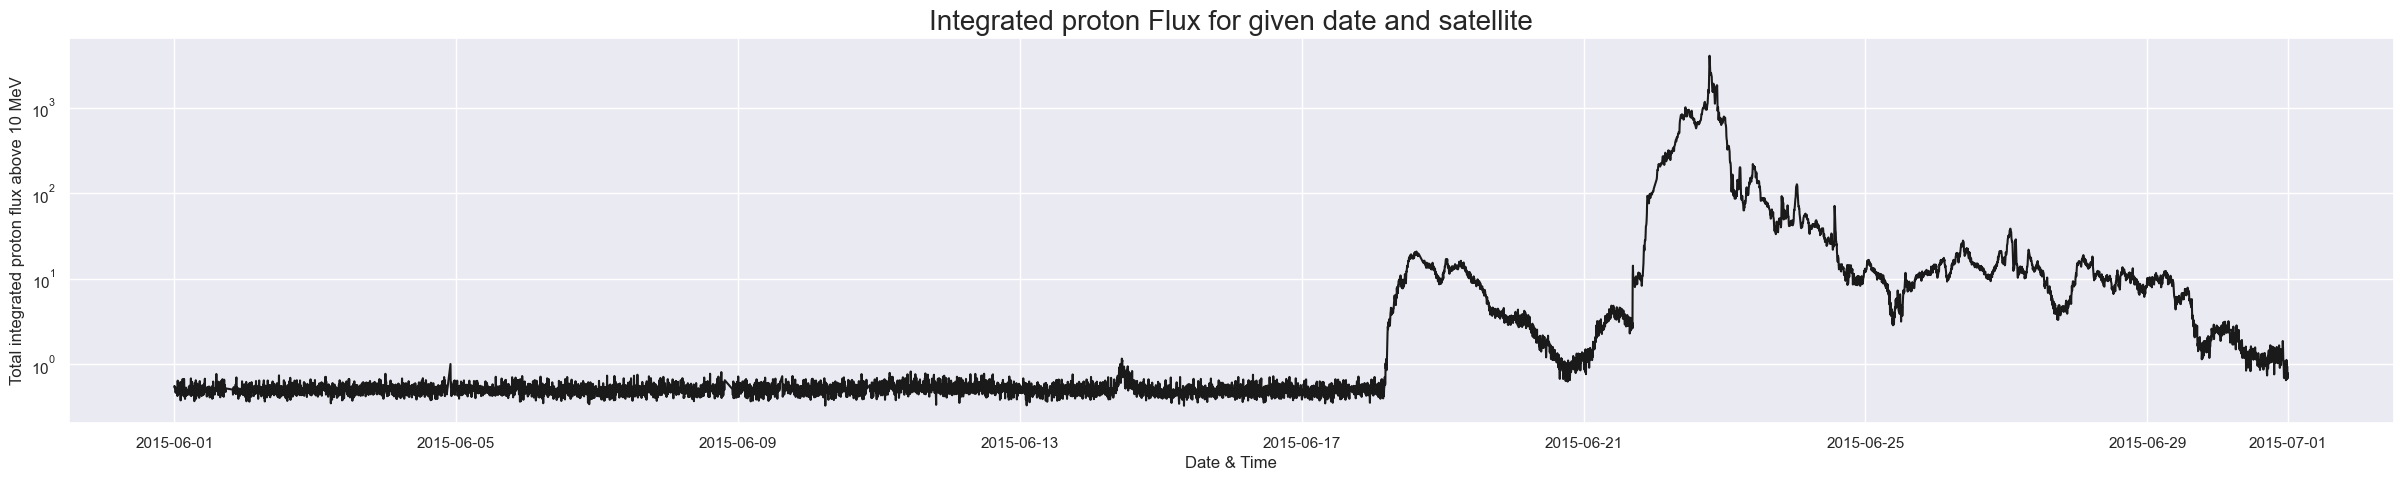

In [121]:
sns.set(rc={"figure.figsize":(30, 5)}) # Set figure size

# Plot total integrated proton flux above 10 MeV on a log scale as a function of time
# Change line colour from blue to black in the interest of accessability
l = sns.lineplot(data=graph, x="time_tag", y="totflux", color='k', legend=False).set(yscale='log')

# Add title and change x and y axis labels
plt.title('Integrated proton Flux for given date and satellite', fontdict = {'fontsize' : 20})
plt.xlabel("Date & Time")
plt.ylabel("Total integrated proton flux above 10 MeV")
plt.savefig('Intprotonfluxfig.png')
plt.show()

Analysis: The highest peak of the total integrated proton flux above 10 MeV on a log scale illustrates the storm level as defined by NOAA, where:

10^1 = level 1 (minor)

10^2 = level 2 (moderate)

10^3 = level 3 (strong)

10^4 = level 4 (severe)

10^5 = level 5 (extreme)

More information on these categories can be found at : https://www.swpc.noaa.gov/noaa-scales-explanation